In [1]:
import sys
import numpy as np
import pandas as pd
sys.path.append('../..')

In [2]:
from tqdm import tqdm
import itertools
from matplotlib import pyplot as plt

In [3]:
from lamarck.assistant import GenomeCreator
from lamarck.assistant import PopulationCreator
from lamarck import Environment

# Setup

#### Process

In [4]:
class Location:
    def __init__(self, x, y):
        self.x = x
        self.y = y
    
    def __repr__(self):
        return ', '.join([f'x: {self.x}', f'y: {self.y}'])
    
    def distance(self, other):
        dx = self.x - other.x
        dy = self.y - other.y
        return np.hypot(dx, dy)
    

class TravelSalesman:
    def __init__(self, n_cities, seed=42):
        self._n = n_cities
        self._seed = seed
        self.coords = []
        self.coord_df = None
        self.build()
    
    def build(self):
        np.random.seed(self._seed)
        self.coords = [Location(*np.random.randint(0, 100, size=2))
                       for _ in range(self._n)]
        coord_data = [(loc.x, loc.y) for loc in self.coords]
        self.coord_df = pd.DataFrame(coord_data, columns=['x', 'y'])
    
    def get_distance(self, id1, id2):
        loc1 = self.coords[id1]
        loc2 = self.coords[id2]
        return loc1.distance(loc2)
    
    def get_route_distance(self, seq):
        if seq is None:
            seq = list(range(self._n))
        dist = 0
        for city1, city2 in zip(seq[0:-1], seq[1:]):
            dist += self.get_distance(city1, city2)
        return dist
    
    
    def plot(self, hl=None, **kw):
        ax = self.coord_df.plot.scatter('x', 'y', xlim=(0, 100), ylim=(0, 100), **kw)
        if hl is not None:
            if isinstance(hl, int):
                self.coord_df[hl:hl+1].plot.scatter('x', 'y', ax=ax, color='m')
            elif isinstance(hl, (list, tuple)):
                [self.coord_df[h:h+1].plot.scatter('x', 'y', ax=ax, color='m')
                 for h in hl]
        plt.gca().set_aspect('equal', adjustable='box')
        return ax
    
    def plot_route(self, seq=None, hl=None, **kw):
        if seq is None:
            seq = list(range(self._n))
        ax = self.coord_df.loc[np.array(seq)]\
            .plot('x', 'y', color='grey', legend=False)
        ax = self.plot(hl=hl, ax=ax, **kw)
        plt.gca().set_aspect('equal', adjustable='box')
        start = seq[0]
        end = seq[-1]
        ax = self.coord_df[start:start+1]\
            .plot.scatter('x', 'y', color='lime', ax=ax)
        ax = self.coord_df[end:end+1]\
            .plot.scatter('x', 'y', color='r', ax=ax)


def process_deco(trav):
    def wrapper(cities):
        return {'dist': trav.get_route_distance(cities)}
    return wrapper

In [5]:
n_cities = 20

In [6]:
trav = TravelSalesman(n_cities, seed=123)

40.11234224026316

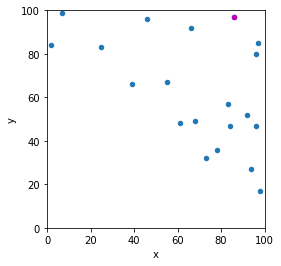

In [7]:
trav.plot(3)
trav.get_distance(2, 3)

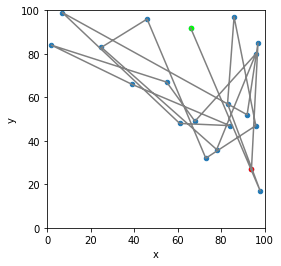

In [8]:
trav.plot_route()

# Finding best - Brute Force

# Finding best - GA

#### Optimization Function

In [9]:
process = process_deco(trav)

#### Genome Creation

In [10]:
genome_creator = GenomeCreator()

In [11]:
genome_creator.add_gene_specs.vectorial(name='cities',
                                        length=n_cities,
                                        replace=False,
                                        domain=tuple(range(n_cities))
                                       )

genome_blueprint = genome_creator.get_genome_blueprint()

In [12]:
genome_blueprint

{'cities': {'type': 'vectorial',
  'domain': (0,
   1,
   2,
   3,
   4,
   5,
   6,
   7,
   8,
   9,
   10,
   11,
   12,
   13,
   14,
   15,
   16,
   17,
   18,
   19),
  'ranges': {'length': 20, 'replace': False}}}

#### Population

In [13]:
ndet=7
nrand=2000

In [37]:
pop_creator = PopulationCreator(genome_blueprint)
pop = pop_creator.create.det(ndet) + pop_creator.create.rand(nrand)
pop.define()
pop

Population with 2007 Creatures with genes cities (vectorial).
        

### Simulate

In [38]:
output = 'dist'
objective = 'min'
n_generations = 100

In [39]:
# Environment
env = Environment()
env.config.set_multi(True)
env.config.set_process(process)

In [40]:
pbar = tqdm(range(n_generations))
for _ in pbar:
    pbar.set_description('Simulating...')
    env.simulate(pop)
    pbar.set_description('Applying Fitness...')
    pop.apply_fitness.single_objective(output, objective=objective)
    pbar.set_description('Selecting...')
    pop.select()
    pbar.set_description('Repopulating...')
    pop.reproduce.mutate(p=0.02)
    pop.reproduce.tournament(n_dispute=3)

Repopulating...: 100%|██████████| 100/100 [00:29<00:00,  3.41it/s]   


<AxesSubplot:xlabel='generation', ylabel='dist'>

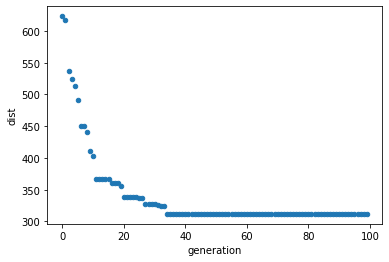

In [48]:
pop.plot.history('dist', min)

In [41]:
gen = 99

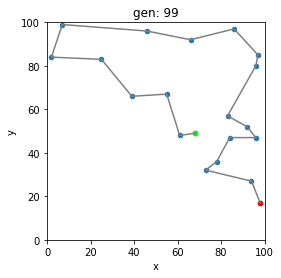

In [42]:
f = pop.datasets.history.generation == gen
df = pop.datasets.history[f]
seq = df.iloc[0]['cities']
trav.plot_route(seq, title=f'gen: {gen}')
gen += 5

In [43]:
c = pop.get_creature.best()
print(c, env.simulate(c))

Creature <2146724110985576160> - genome: {'cities': (10, 15, 11, 13, 7, 12, 16, 6, 0, 3, 18, 9, 2, 17, 4, 14, 8, 5, 19, 1)} {'dist': 311.7965347235479}


302.3768450963021

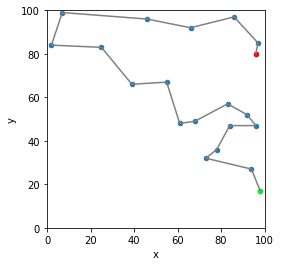

In [44]:
best_seq = (1, 19, 5, 8, 14, 4, 17, 2, 10, 15, 11, 13, 7, 12, 16, 6, 0, 3, 18, 9)
trav.plot_route(best_seq)
trav.get_route_distance(best_seq)